In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

# Correct dataset structure should be:
# /kaggle/input/wheat1/
# ├── Class1/
# │   ├── img1.jpg
# │   └── img2.jpg
# ├── Class2/
# │   ├── img1.jpg
# └── ...

# dataset_path = "/kaggle/input/pest-dataset/Aug_Pest_Dataset"
dataset_path = "/kaggle/input/pest-data-set-agriculture/augmented_dataset"


In [2]:
selected_classes = [
    '62', '61', '56', '73', '80', '75', '65', '43', '72', '98',  
    '79', '15', '81', '63', '25', '35', '96', '31', '74', '82',  
    '53', '78', '94', '30', '67', '85', '36', '58', '48', '14'    
]

# Create proper train/validation/test splits (70-15-15)
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3  # 30% for validation + test
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.5  # Split validation into test (50% of 30% = 15%)
)

# Train generator (70%)
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    classes=selected_classes, 
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Validation generator (15%)
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    classes=selected_classes, 
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

# Test generator (15%)
test_generator = test_datagen.flow_from_directory(
    dataset_path,
    classes=selected_classes, 
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

Found 21000 images belonging to 30 classes.
Found 9000 images belonging to 30 classes.
Found 15000 images belonging to 30 classes.


In [3]:
# Build model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = False

# Add custom head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Initial training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 484s 1s/step - accuracy: 0.3359 - loss: 2.4469 - val_accuracy: 0.7523 - val_loss: 0.9335
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.6564 - loss: 1.2007 - val_accuracy: 0.8093 - val_loss: 0.7049
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.7134 - loss: 0.9857 - val_accuracy: 0.8374 - val_loss: 0.5910
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.7557 - loss: 0.8343 - val_accuracy: 0.8506 - val_loss: 0.5210
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.7749 - loss: 0.7676 - val_accuracy: 0.8684 - val_loss: 0.4537
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.8045 - loss: 0.6837 - val_accuracy: 0.8767 - val_loss: 0.4343
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.8066 - loss: 0.6618 - val_accuracy: 0.8912 - val_loss: 0.3766
Epoch 8/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.8184 - loss: 0.6249 - val_accuracy: 0.895

In [4]:
# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:--int(len(base_model.layers)*0.25)]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.6713 - loss: 1.2672 - val_accuracy: 0.9250 - val_loss: 0.2606
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.8150 - loss: 0.6418 - val_accuracy: 0.9281 - val_loss: 0.2548
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.8499 - loss: 0.5194 - val_accuracy: 0.9371 - val_loss: 0.2272
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.8693 - loss: 0.4382 - val_accuracy: 0.9406 - val_loss: 0.2159
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.8869 - loss: 0.3853 - val_accuracy: 0.9440 - val_loss: 0.2064
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.8927 - loss: 0.3645 - val_accuracy: 0.9450 - val_loss: 0.2029
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.9033 - loss: 0.3335 - val_accuracy: 0.9480 - val_loss: 0.1832
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.9086 - loss: 0.3135 - val_accu

In [5]:
# Evaluation
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 61s 260ms/step - accuracy: 0.9715 - loss: 0.0940

Final Test Accuracy: 96.03%
Final Test Loss: 0.1355


In [6]:
# Classification Report
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Use class names and labels from the training generator to ensure consistency with the model
class_names = list(train_generator.class_indices.keys())
labels = list(train_generator.class_indices.values())

print(classification_report(y_true, y_pred_classes, target_names=class_names, labels=labels))

235/235 ━━━━━━━━━━━━━━━━━━━━ 68s 276ms/step
              precision    recall  f1-score   support

          62       0.99      0.98      0.98       500
          61       0.99      1.00      1.00       500
          56       0.98      0.97      0.98       500
          73       0.98      0.95      0.97       500
          80       0.97      1.00      0.98       500
          75       1.00      0.97      0.98       500
          65       0.99      0.99      0.99       500
          43       0.99      0.95      0.97       500
          72       0.99      1.00      0.99       500
          98       0.99      0.99      0.99       500
          79       0.98      0.94      0.96       500
          15       0.94      0.96      0.95       500
          81       0.98      0.99      0.99       500
          63       0.98      1.00      0.99       500
          25       0.95      0.93      0.94       500
          35       0.99      0.94      0.96       500
          96       0.98      0.96    

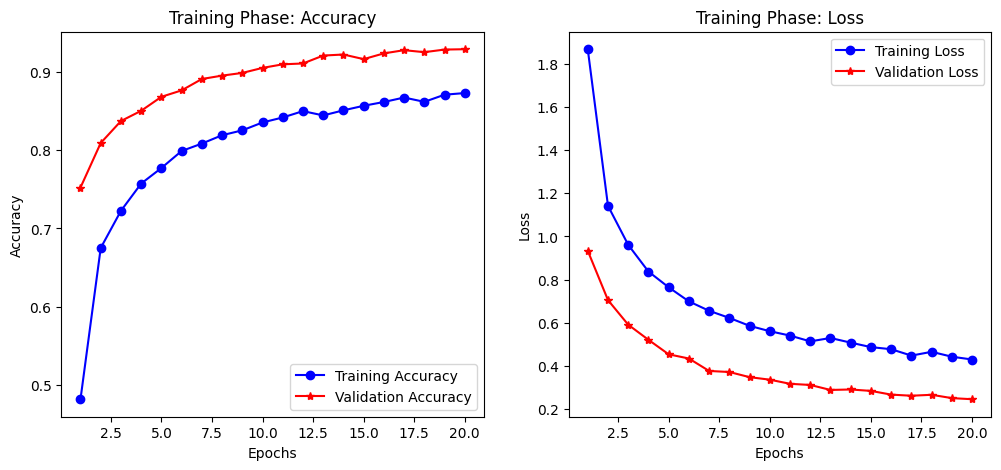

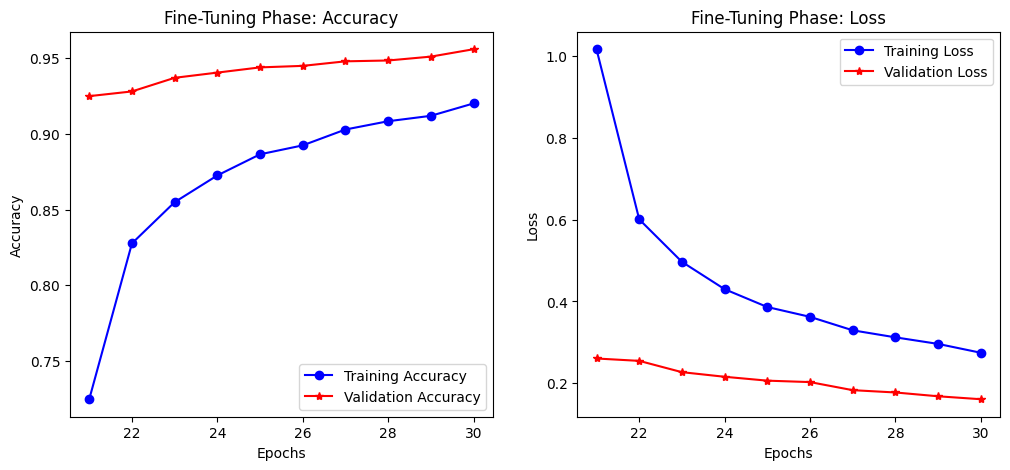

In [7]:
import matplotlib.pyplot as plt

# Extract training and fine-tuning history separately
train_epochs = len(history.history['accuracy'])  # Should be 20
fine_tune_epochs = len(history_fine.history['accuracy'])  # Should be 10

# Training phase data (First 20 epochs)
train_acc = history.history['accuracy']
train_val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
train_epochs_range = range(1, train_epochs + 1)

# Fine-tuning phase data (Last 10 epochs)
fine_tune_acc = history_fine.history['accuracy']
fine_tune_val_acc = history_fine.history['val_accuracy']
fine_tune_loss = history_fine.history['loss']
fine_tune_val_loss = history_fine.history['val_loss']
fine_tune_epochs_range = range(train_epochs + 1, train_epochs + fine_tune_epochs + 1)

# Plot Training Phase
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_epochs_range, train_acc, 'bo-', label='Training Accuracy')
plt.plot(train_epochs_range, train_val_acc, 'r*-', label='Validation Accuracy')
plt.title('Training Phase: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_epochs_range, train_loss, 'bo-', label='Training Loss')
plt.plot(train_epochs_range, train_val_loss, 'r*-', label='Validation Loss')
plt.title('Training Phase: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plot Fine-Tuning Phase
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_epochs_range, fine_tune_acc, 'bo-', label='Training Accuracy')
plt.plot(fine_tune_epochs_range, fine_tune_val_acc, 'r*-', label='Validation Accuracy')
plt.title('Fine-Tuning Phase: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fine_tune_epochs_range, fine_tune_loss, 'bo-', label='Training Loss')
plt.plot(fine_tune_epochs_range, fine_tune_val_loss, 'r*-', label='Validation Loss')
plt.title('Fine-Tuning Phase: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()